## DSGE w. Feedback - Numerical Simulations

### Imports

In [89]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [91]:
import model

## Simulation mechanics

In [92]:
# CES
def lhs_CES(cons: float, z: float, k:float, alpha: float, gamma: float, r: float, rho: float) -> float:
        pt1 = 2 * gamma * (1+r) / ((z ** 2) * (1 - alpha) ** (2 / rho))
        pt2 = cons ** 2
        pt3 = (1 - alpha*(z * k / cons) ** rho) ** ((2 - rho) / rho)
        return pt1 * pt2 * pt3

def rhs_CES(cons: float, gti: float, ft: float) -> float:
    return 1 - (ft * cons) / (gti - cons)
    

def bisection_CES(z:float, income:float, k:float, gt_:float, ft_:float, p:dict, err:float=1e-5)->float:
    
    # Define the left and right hand sides of the equations
    diff = lambda c: rhs_CES(c, gt_ * income, ft_) - lhs_CES(c, z, k, p['alpha'], p['gamma'], p['interest'], p['rho'])

    # Initial guess at the next options for 
    guess = np.min([gt_*income, k * z * (1 / p['alpha']) ** (-1 / p['rho'])])
    x = [0, guess / 2, guess]
    abs_lst = [abs(diff(i)) for i in x[:2]]
    
    # Apply bi-section method
    while min(abs_lst) >= err:
        test = np.sign([diff(i) for i in x])

        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]

        abs_lst = [abs(diff(i)) for i in x[:2]]

    return x[np.argmin(abs_lst)]

In [108]:
def step(t: float, x: np.ndarray, p: dict):
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, gt_, ft_, news_, inc_, xiz_, xin_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
        
    # Income and Investment
    income = (w_ * n_ + b_  + q_ * k_) / (1 + p['inflation'])
    
    # Capital Markets
    k = (1 - p['depreciation']) * k_ + income * (1 - gt_)

    # Household decision
    c = bisection_CES(z, income, k, gt_, ft_, p)
    n = (c ** 2) / (4 * k * (z ** 2))
    b = (gt_ * income - c) * (1 + p['interest'])
    
    # Firm decisions
    temp = (p['alpha'] * k ** p['rho'] + (1 - p['alpha']) * n ** p['rho']) ** ((1 / p['rho']) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (p['rho'] - 1))
    q = p['alpha'] * z * temp * (k ** (p['rho'] - 1))

    # News
    xin = np.random.normal(0, p['sigmaN'])
    info = p['n_cons']*(c/c_ - 1)
    news = np.tanh(p['n_theta'] * (p['n_persistence'] * news_ + (1 - p['n_persistence']) * info + xin))
    
    if t > 300 and t < 400:
        if p['shock'] == -1:
            news = -1
        elif p['shock'] == 1:
            news = 1
    
    # Household modifiers
    gt = 0.5 * (p['g_max'] + p['g_min'] - news * (p['g_max'] - p['g_min']))
    ft = 0.5 * (p['f_max'] + p['f_min'] - news * (p['f_max'] - p['f_min']))
    
    return z, c, n, b, w, k, q, gt, ft, news, income, xiz, xin

In [94]:
def simulate(start: np.ndarray, p: dict, t_end: float = 1e3):
    x = np.empty((int(t_end), len(start)))
    x[0, :] = start
    for t in range(1, int(t_end)):
        x[t, :] = step(t, x[t - 1, :], p)
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'gt', 'ft', 'news', 'income', 'xiz', 'xin']
    df = pd.DataFrame(x, columns=cols)
    df.loc[:,'inv'] = 100*(1-df.loc[:,'gt'])
    df.loc[:,'bc'] = df.b / df.c
    return df

----
## Interactive Analysis

<ipython-input-92-d05550287b31>:5: RuntimeWarning: divide by zero encountered in double_scalars
  pt3 = (1 - alpha*(z * k / cons) ** rho) ** ((2 - rho) / rho)
<ipython-input-92-d05550287b31>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (ft * cons) / (gti - cons)


<IPython.core.display.Javascript object>


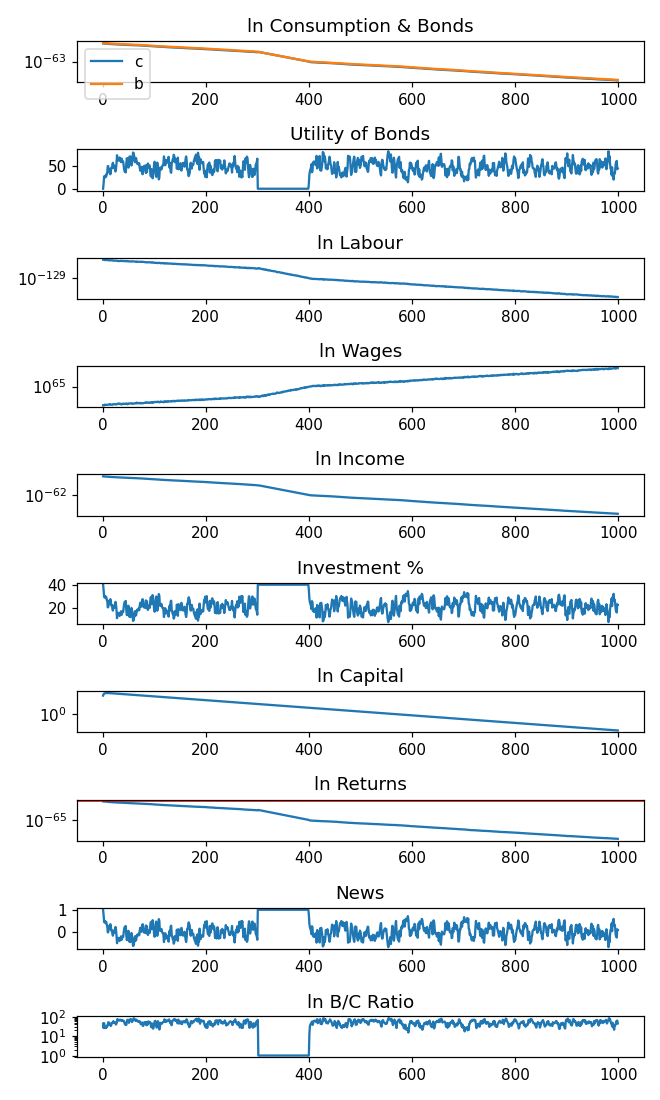

In [107]:
params = {'etaZ': 0.2, 'sigmaZ': 0.8, 'zbar': 1.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.015, 'depreciation': 0.01, 
          'g_min': 0.6, 'g_max': 0.99, 'f_min': 1.0, 'f_max': 100, 
          'n_cons': .2, 'n_theta': 1, 'n_persistence': 0.8, 
          'gamma': 1.0, 'alpha': 0.5, 'rho': -1e-1, 'shock': 1.0}

start = dict(z=1, c=100, n=100, b=100, w=1, k=100, q=0.1, 
             gt=0.8, ft=.5, income=100, news=1, xiz=0, xin=0)
start = np.array([v for _,v in start.items()])

T = 1e3
np.random.seed(40)
view = (1, int(1e3))


df = simulate(start, params, T)
df = df.iloc[view[0]:view[1],:]

graphs = {
        'ln Consumption & Bonds' : [df.loc[:,['c','b']], True],
        'Utility of Bonds' : [df.ft, False],
        'ln Labour' : [df.n, True],
        'ln Wages' : [df.w, True],
        'ln Income' : [df.income, True],
        'Investment %' : [df.inv, False],
        'ln Capital' : [df.k, True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
        'ln B/C Ratio' : [df.bc, True],
    }


axs = model.simulation_graph(graphs, size = (6, 10))
axs['ln Returns'].axhline(params['interest'], color='red', linewidth=0.5)


In [38]:
param_bounds = {
    # Restrict noise params to be constant
    'etaZ': (0.2,0.2), 'sigmaZ': (0.8,0.8), 'sigmaN': (0.2,0.2), 
    # Realistic monthly values - 0% to 5%
    'inflation': (0.0,0.05), 'interest': (0.0,0.05), 'depreciation': (0.0,0.05),
    # Saving and bond parameters
    'g_min': (0.0,0.99), 'g_max': (0.0,0.99), 'f_min': (0.0,1e1), 'f_max': (1e1,1e3),
    # News parameters
    'n_cons': (0.1,10), 'n_theta': (0.1,10), 'n_persistence': (0.0,0.99),
    # Production & Household
    'zbar': (1.0,1.0), 'gamma': (1.0,10.0), 'alpha': (0.1,0.9), 'rho': (-1e4,-1e-1), 
    # No shocks for now
    'shock': (0.0,0.0)}

n = 5
param_steps = {'etaZ': 0, 'sigmaZ': 0, 'sigmaN': 0, 'inflation': 0, 'interest': 0, 'depreciation': 0,
    'g_min': n, 'g_max': n, 'f_min': n, 'f_max': n, 'n_cons': n, 'n_theta': n, 'n_persistence': n,
    'zbar': 0, 'gamma': 0, 'alpha': n, 'rho': n, 'shock': 0}

In [24]:
# Generate the whole set of parameters
params = {'etaZ': 0.2, 'sigmaZ': 0.8, 'zbar': 1.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.01, 
          'g_min': 0.8, 'g_max': 0.99, 'f_min': 1.0, 'f_max': 100, 
          'n_cons': 1, 'n_theta': 1, 'n_persistence': 0.8, 
          'gamma': 1.0, 'alpha': 0.5, 'rho': -1, 'shock': 0.0}

constants = [k for k,v in param_steps.items() if v==0]
ranges = {k:np.linspace(*v, param_steps[k]) for k,v in param_bounds.items()}
ranges = {k:v for k,v in ranges.items() if v.size!=0}

In [25]:
results = pd.DataFrame(columns = list(ranges.keys()))

In [26]:
from itertools import product

var = list(ranges.keys())

for tup in product(*list(ranges.values())):
    # Generate unique parameter set
    p = dict(params)
    for combo in zip(var, tup):
        p[combo[0]] = combo[1]
    #df = simulate(start)


In [13]:
def dead_economy(df, epsilon):
    return df.c.iloc[-1] < epsilon